Generating large amounts of pseudorandom numbers based on PRNG

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator,FormatStrFormatter,MaxNLocator
import xml.etree.ElementTree as Xet

In [11]:
def lfsr(seed, taps, length):
    """Generate a LFSR sequence of a given length."""
    # Convert seed to binary representation with 32 bits
    register = np.array([int(bit) for bit in f"{seed:032b}"], dtype=np.uint8)
    output = np.empty(length, dtype=np.uint8)
    
    for i in range(length):
        new_bit = np.bitwise_xor.reduce(register[taps])
        # Shift the register and insert the new bit at the end
        register[:-1] = register[1:]
        register[-1] = new_bit
        # Save output bit
        output[i] = register[0]
    
    return output
    
def insert_sequence_into_db(cursor, taps, sequence):
    """Inserts the generated sequence into the database."""
    # Convert the sequence from np.array to a string representation of binary numbers
    binary_str = ''.join(map(str, sequence))
    taps_str = ','.join(map(str, taps))  # Convert taps list to string
    cursor.execute('''
        INSERT INTO kissat_data (taps, output_binary)
        VALUES (?, ?)
    ''', (taps_str, str(int(binary_str, 2))))  # Convert binary string to integer before storing


In [9]:
import sqlite3
#   Uncomment this to create your own local database, ideally with a different name for each solver
"""
conn = sqlite3.connect('prng_data.db')
cursor = conn.cursor()

# Also change here!
cursor.execute('''
    CREATE TABLE IF NOT EXISTS kissat_data ( 
        id INTEGER PRIMARY KEY,
        taps TEXT,
        output_binary TEXT
    )
''')

# Close the connection
conn.close()
"""


In [45]:
# Connect to SQLite database
conn = sqlite3.connect('prng_data.db')
cursor = conn.cursor()

# Parameters for LFSR
seeds = [1]  # Add more seeds if you want to generate more sequences
taps_list = [[31, 30, 1, 0,29,26],]  # First is what we use, second is XORMIX (soon)
length = 1000  # Length of the sequence to generate

# Generate and insert sequences into the database
for seed in seeds:
    for taps in taps_list:
        sequence = lfsr(seed, taps, length)
        insert_sequence_into_db(cursor, taps, sequence)

# Commit changes and close the connection
conn.commit()
conn.close()

In [46]:
import sqlite3
import numpy as np

def get_sequences_from_db(db_path):
    """Retrieve sequences from the database and convert them to binary arrays."""
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute('SELECT taps, output_binary FROM kissat_data')
    data = cursor.fetchall()
    conn.close()
    
    sequences = []
    for taps, sequence in data:
        # Assuming sequence is stored as integer, convert back to binary array
        binary_str = format(int(sequence), 'b')  # Convert integer back to binary string
        binary_array = np.array([int(bit) for bit in binary_str], dtype=np.uint8)
        sequences.append((taps, binary_array))
    
    return sequences

In [47]:
def compute_autocorrelation(sequence):
    """Compute the autocorrelation of a binary sequence."""
    # Bnary to +1/-1 to have zero mean
    sequence_adjusted = 2 * sequence - 1
    autocorr = np.correlate(sequence_adjusted, sequence_adjusted, mode='full')
    # Normalize by sequence length
    autocorr_normalized = autocorr / np.max(autocorr)
    # Return positive lags
    return autocorr_normalized[autocorr_normalized.size // 2:]

In [48]:
import matplotlib.pyplot as plt

def plot_autocorrelation(autocorr):
    """Plot the autocorrelation of a sequence."""
    plt.figure(figsize=(14, 7))
    lags = np.arange(len(autocorr))[::2]
    plt.plot(lags, autocorr[::2], marker='o', linestyle='-', markersize=4)
    plt.title(f'Autocorrelation for Taps {taps}')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Autocorrelation for taps 31,30,1,0:


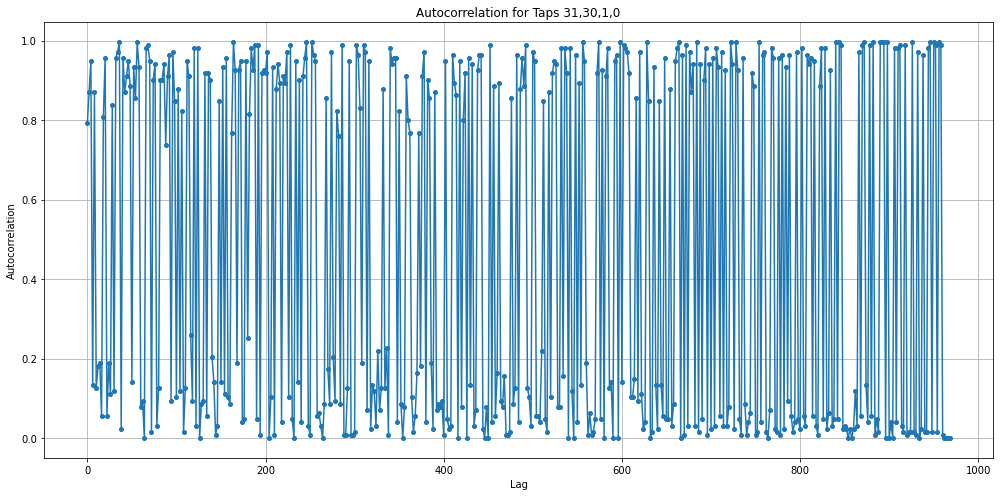

Autocorrelation for taps 31,30,1,0:


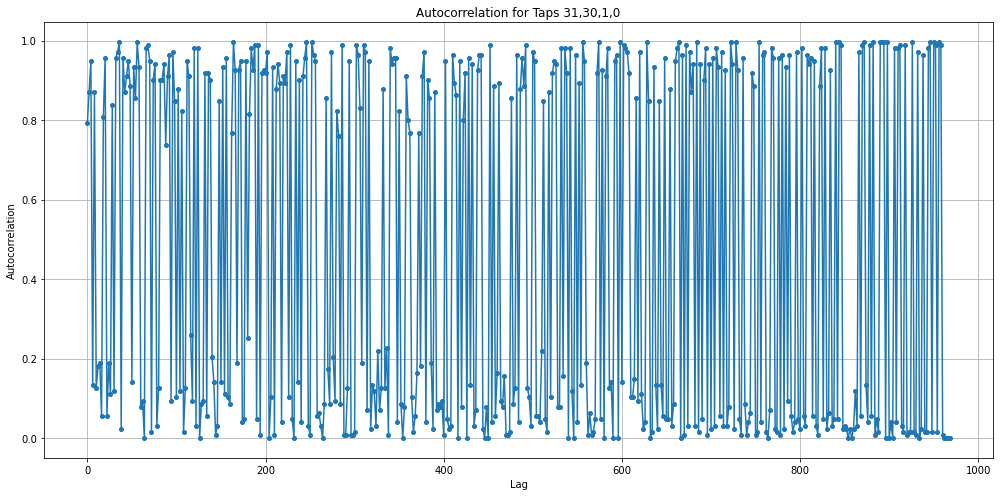

Autocorrelation for taps 31,30,1,0:


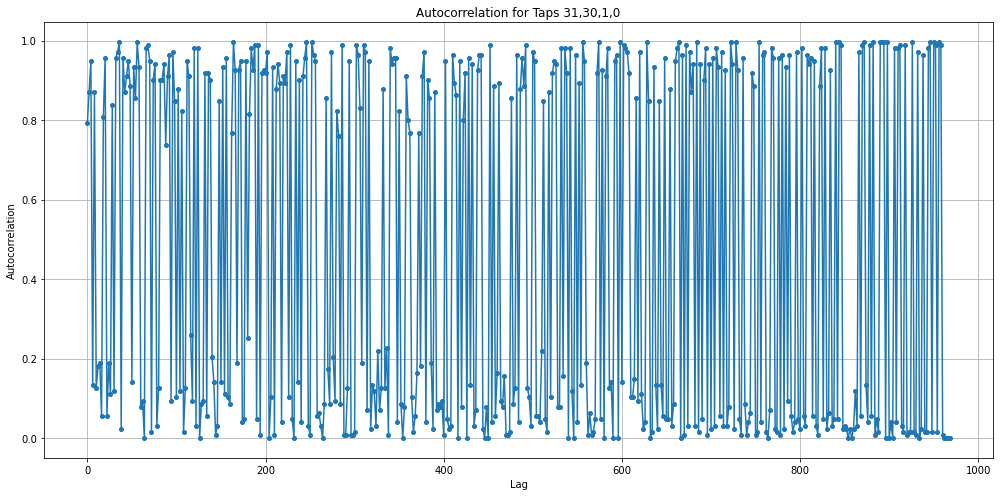

Autocorrelation for taps 31,30,1,0:


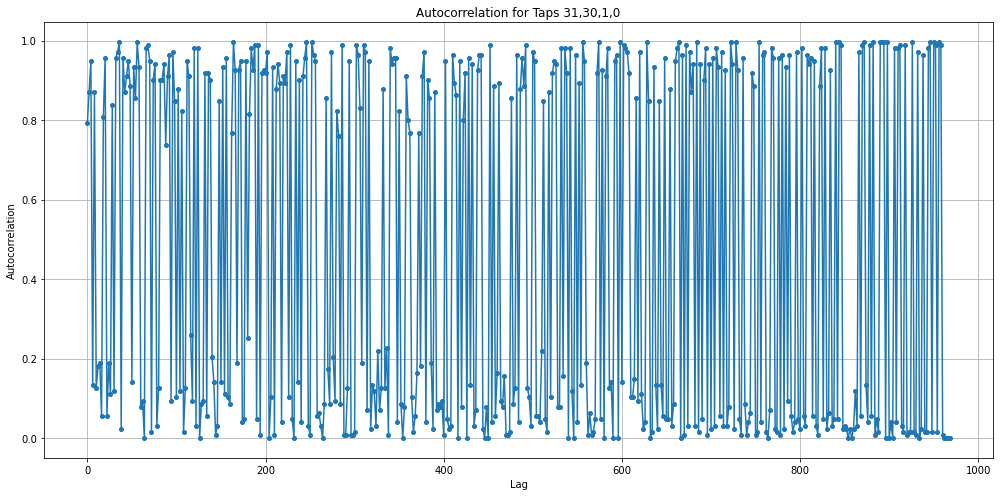

Autocorrelation for taps 31,30,1,0:


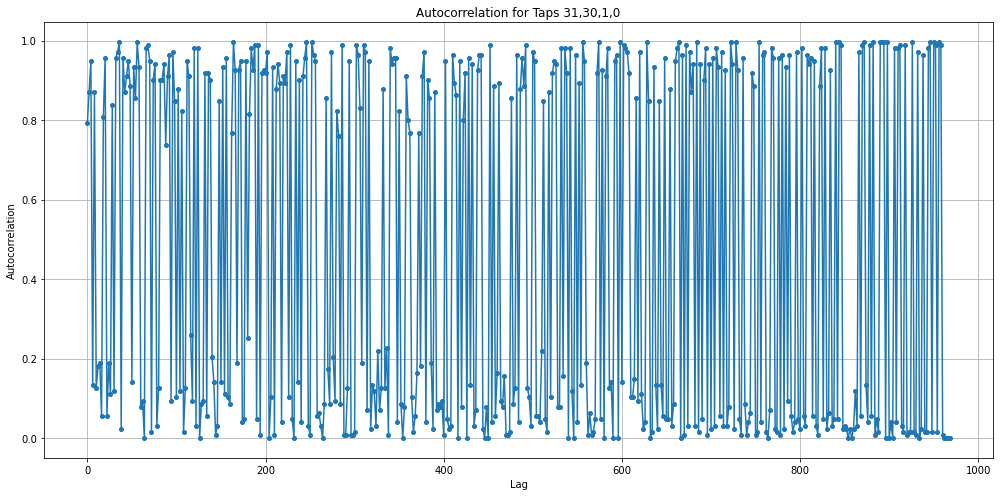

Autocorrelation for taps 31,30,1,0,29,26:


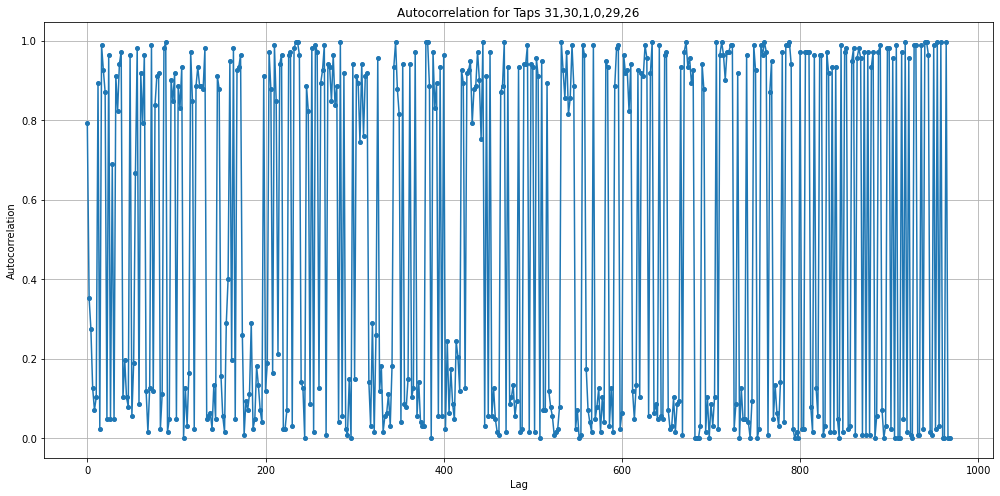

In [49]:
db_path = 'prng_data.db'
sequences = get_sequences_from_db(db_path)

for taps, sequence in sequences:
    autocorr = compute_autocorrelation(sequence)
    print(f"Autocorrelation for taps {taps}:")
    plot_autocorrelation(autocorr)

So yes, this is pretty terrible. Thankfully the XORMIX algorithm does better, already passed DIEHARD tests, and is open source. So let's use that as our PRNG.